In [65]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose, Resize
import matplotlib.pyplot as plt

In [66]:
# 說實在我也不知道為什麼要加這個 如果不加028電腦跑不動
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

## Setting

In [67]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('use', device)

use cuda


In [68]:
# Hyper-parameter
epochs = 50
batch_size = 256

In [69]:
transform = Compose([ToTensor(), Resize((96, 96)), Normalize(0, 1)])

In [70]:
train_data = FashionMNIST('data', train=True, transform=transform, download=True)
test_data = FashionMNIST('data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=batch_size, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, pin_memory=True, shuffle=False)

## Build ResNet

In [71]:
class ResidualBlock(nn.Module):
    def __init__(self, num_channel, protect=False, strides=1):
        super(ResidualBlock, self).__init__()
        
        self.need_protect = protect or strides > 1
        
        self.cnn_1 = nn.LazyConv2d(num_channel, kernel_size=3, padding=1, stride=strides)
        self.bn_1 = nn.BatchNorm2d(num_channel)
        self.cnn_2 = nn.LazyConv2d(num_channel, kernel_size=3, padding=1)
        self.bn_2 = nn.BatchNorm2d(num_channel)
        self.relu = nn.ReLU()
        
        if self.need_protect:
            self.protect = nn.LazyConv2d(num_channel, kernel_size=1, stride=strides)
        
    def forward(self, X):
        Y = self.cnn_1(X)
        Y = self.bn_1(Y)
        Y = self.relu(Y)
        
        Y = self.cnn_2(Y)
        Y = self.bn_2(Y)
        Y = self.relu(Y)
        
        if self.need_protect:
            protect = self.protect(X)
        else:
            protect = X
        Y = Y + protect
        
        return self.relu(Y)

### Build My Model

In [72]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        residual_block = [
            ResidualBlock(64, protect=True),
            ResidualBlock(128, strides=2, protect=True),
            ResidualBlock(256, strides=2, protect=True),
            ResidualBlock(512, strides=2, protect=True),
        ]
        
        self.net = nn.Sequential(
            *residual_block
        )

        self.start = nn.Sequential(
                    nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
                    nn.LazyBatchNorm2d(), nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                    )
        
        self.last = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.LazyLinear(10)
        )
        
    def forward(self, X):
        X = self.start(X)
        X = self.net(X)
        X = self.last(X)
        return X

In [73]:
model = Model(); model.to(device)
loss = CrossEntropyLoss()
optimizer = Adam(model.parameters())
# schduler

In [74]:
from torchsummary import summary
summary(model, (1, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           3,200
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,928
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,928
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
           Conv2d-11           [-1, 64, 24, 24]           4,160
             ReLU-12           [-1, 64, 24, 24]               0
    ResidualBlock-13           [-1, 64, 24, 24]               0
           Conv2d-14          [-1, 128,

## Start Training

In [75]:
history = {
    'acc':[],
    'loss':[],
    'val_acc':[],
    'val_loss':[],
}

In [76]:
def record(acc, loss, val_acc, val_loss, needPrint=False):
    global history
    history['acc'].append(acc)
    history['val_acc'].append(val_acc)
    history['loss'].append(loss)
    history['val_loss'].append(val_loss)
    
    if needPrint:
        print(f'Training acc {acc:.4f}, loss {loss:.4f}')
        print(f'Test acc {val_acc:.4f}, loss {val_loss:.4f}')

In [77]:
last_val_acc = -1
best_val_acc = -1
count = 0
def EarlyStopping(patience=5, filepath='model.pt'):
    global history, model, last_val_acc, count, best_val_acc
    if best_val_acc < history['val_acc'][-1]:
        torch.save(model.state_dict(), filepath)
        print('\033[33m' + 'Save' + '\033[0m')
        best_val_acc = history['val_acc'][-1]
    else:
        if last_val_acc >= history['val_acc'][-1]: 
            count += 1    
        print('Not improved ' + '\033[38;5;236m' + 'Tu es nul :)' + '\033[0m')
        
    last_val_acc = history['val_acc'][-1]
        
    if count == patience: return True
    return False

In [78]:
for i in range(epochs):
    print(f'Epoch {i + 1} Start')
    
    model.train()
    train_acc = 0
    train_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        img, label = data
        img, label = img.to(device), label.to(device)
        
        output = model(img)
        output_loss = loss(output, label)
        # Record
        train_acc += (output.argmax(dim=1) == label).sum().item()
        train_loss += output_loss.item()
        # BP
        output_loss.backward()
        optimizer.step()
    train_acc /= len(train_data)
    train_loss /= len(train_loader)
    
    model.eval()
    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            img, label = data
            img, label = img.to(device), label.to(device)
            
            output = model(img)
            output_loss = loss(output, label)
            # Record
            test_acc += (output.argmax(dim=1) == label).sum().item()
            test_loss += output_loss.item()
    
    test_acc /= len(test_data)
    test_loss /= len(test_loader)
    
    record(train_acc, train_loss, test_acc, test_loss, True)
    if EarlyStopping(5): break
    print('==================================')

Epoch 1 Start
Training acc 0.8685, loss 0.3567
Test acc 0.8734, loss 0.3325
Save
Epoch 2 Start
Training acc 0.9164, loss 0.2278
Test acc 0.9113, loss 0.2322
Save
Epoch 3 Start
Training acc 0.9306, loss 0.1886
Test acc 0.8793, loss 0.3794
Not improved Tu es nul :)
Epoch 4 Start
Training acc 0.9420, loss 0.1582
Test acc 0.9225, loss 0.2166
Save
Epoch 5 Start
Training acc 0.9507, loss 0.1342
Test acc 0.9064, loss 0.2794
Not improved Tu es nul :)
Epoch 6 Start
Training acc 0.9584, loss 0.1120
Test acc 0.8844, loss 0.3324
Not improved Tu es nul :)
Epoch 7 Start
Training acc 0.9663, loss 0.0890
Test acc 0.9182, loss 0.2466
Not improved Tu es nul :)
Epoch 8 Start
Training acc 0.9722, loss 0.0742
Test acc 0.9173, loss 0.2577
Not improved Tu es nul :)
Epoch 9 Start
Training acc 0.9771, loss 0.0609
Test acc 0.9157, loss 0.2849
Not improved Tu es nul :)


## Plot Outcome

In [79]:
def plot_perfomance(name):
    global device, history
    plt.plot(history[name], 'b', label='train')
    plt.plot(history['val_' + name], 'r', label='val')
    plt.title('Performance')
    plt.ylabel(name)
    plt.xlabel('Epoch')
    plt.show()

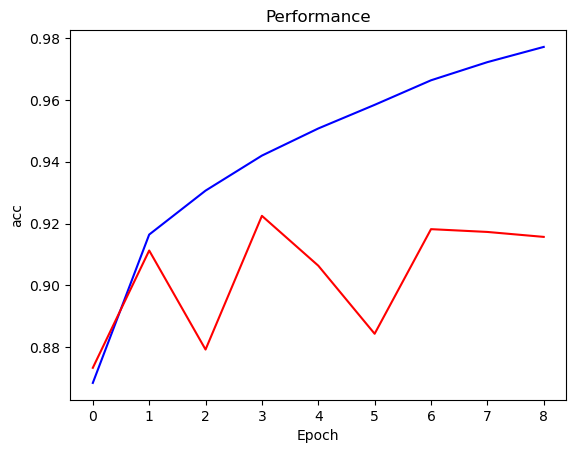

In [80]:
plot_perfomance('acc')

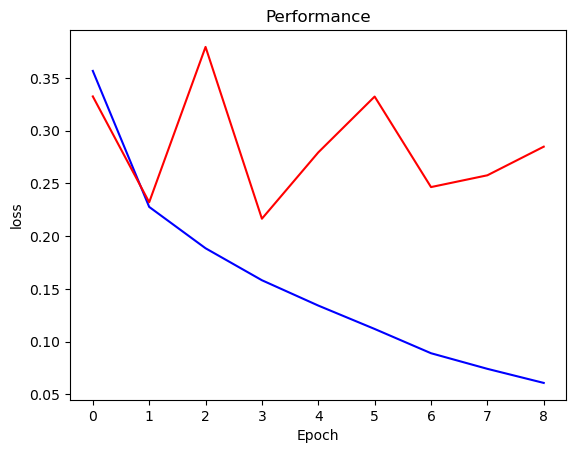

In [81]:
plot_perfomance('loss')

In [82]:
model.load_state_dict(torch.load('model.pt', weights_only=True))

true_label = torch.tensor([], dtype=int)
pred_label = torch.tensor([], dtype=int)

model.eval()
for data in test_loader:
    img, label = data
    img, label = img.to(device), label.to(device)
    
    true_label = torch.cat((true_label, label.cpu().detach()))
    
    output = model(img).argmax(dim=1).cpu().detach()
    pred_label = torch.cat((pred_label, output))

In [83]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

print('\033[33m' + 'Accuracy' + '\033[0m', round(accuracy_score(true_label, pred_label), 4))
print('\033[33m' + 'Classification Report' + '\033[0m')
print(classification_report(true_label, pred_label, target_names=[train_data.classes[i] for i in range(10)]))

Accuracy 0.9225
Classification Report
              precision    recall  f1-score   support

 T-shirt/top       0.89      0.88      0.88      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.83      0.93      0.87      1000
       Dress       0.89      0.96      0.92      1000
        Coat       0.89      0.86      0.88      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.85      0.70      0.77      1000
     Sneaker       0.98      0.96      0.97      1000
         Bag       0.97      0.99      0.98      1000
  Ankle boot       0.95      0.98      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



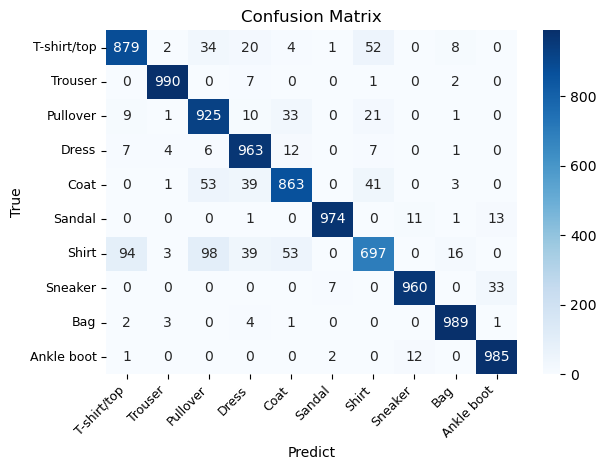

In [84]:
cm = confusion_matrix(true_label, pred_label)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predict')
plt.yticks([i + 0.5 for i in range(10)], [test_data.classes[i] for i in range(10)], rotation=0, fontsize=9)
plt.xticks([i + 0.5 for i in range(10)], [test_data.classes[i] for i in range(10)], rotation=45, ha='right', fontsize=9)
plt.tight_layout()
plt.show()